In [56]:
import os, sys, glob
import itertools

%matplotlib inline
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import astropy.io.ascii as at
from astropy.io import fits
import astropy.units as u
from astropy import table
from astropy.table import join,vstack,Table
from astropy.coordinates import SkyCoord

import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(vmin=0, vmax=5)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

from analyze_cluster_output import colors, shapes
from plot_periods import plot_periodcolor_histogram

In [2]:
clusters = ["IC_2391","Collinder_135","NGC_2451A","NGC_2547","IC_2602"]
dates = ["2021-06-22","2021-06-18","2021-06-21","2021-06-21","2021-07-02"]

In [45]:
class SpinModel:
    
    def __init__(self,model,model_age,period_scale):
        mod_file = os.path.expanduser(f"~/Dropbox/Models/UpSco_{model}/UpSco_{model}_{model_age:05d}Myr.txt")
    #     print(mod_file)
        mod = at.read(mod_file,names=["mass","prot"])
        
        self.mass_bins = np.arange(0.025,1.4,0.1)

        self.period_scale = period_scale
        if period_scale=="log":
#             self.period_bins = np.logspace(np.log10(0.08),np.log10(40),200)
            self.period_bins = np.logspace(np.log10(0.08),np.log10(40),30)
        else:
            self.period_bins = np.linspace(0,40,30)
#             self.period_bins = np.linspace(0,40,10)

        # Calculate the histogram
        img_raw, self.xedges, self.yedges = np.histogram2d(mod["mass"],mod["prot"],
                                                           bins=[self.mass_bins,self.period_bins])
        # Transpose the image so we can actually plot it
        # by default this is not normalized
        self.img = img_raw.T
        
        self.mass_array = mod["mass"]
        self.prot_array = mod["prot"]

    def normalize(self):
        # Normalize the histogram if desired
        # calculate dM and dP
        dmass = np.diff(self.mass_bins)
        dper = np.diff(self.period_bins)
        
        # Each mass bin should contain (1/nmass)*(1/dmass) of the probability
        nmass = len(dmass)
        
        img_nomask = np.copy(self.img)
        
        # Multiply by dP, to sum correctly
        img_nomask_dp = img_nomask * dper[:,np.newaxis]
        # Then add up the probability in each mass bin
        sum_over_p = np.sum(img_nomask_dp, axis=0)
        # Then normalize each mass bin
        img_nomask_mnorm1 = img_nomask / sum_over_p
        img_nomask_final = img_nomask_mnorm1 / nmass / dmass

        self.img = img_nomask_final
        
    def add_mask(self):
        img_nomask = np.copy(self.img)
        
        # mask the image so it doesn't show cells outside the model
        model_exists = np.ones(np.shape(img_nomask),bool)
        mask = np.zeros(np.shape(img_nomask),bool)
        for i in range(len(self.mass_bins)-1):
            mass_loc = ((self.mass_array>=self.mass_bins[i]) & 
                        (self.mass_array<self.mass_bins[i+1]))
            # Calculate whether there are periods in each individual bins
            for j in range(len(self.period_bins)-1):
                per_loc = ((self.prot_array>=self.period_bins[j]) & 
                           (self.prot_array<self.period_bins[j+1]))
                in_this_bin = np.where(mass_loc & per_loc)[0]
    #             print(mass_bins[i],period_bins[j],in_this_bin)
                if len(in_this_bin)==0:
                    model_exists[j,i] = False
            # Now, for this mass range, define the mask to only exclude bins
            # beyond the range of the model
    #         print(model_exists[:,i])
            mod_min_j = min(np.where(model_exists[:,i]==True)[0])
            mod_max_j = max(np.where(model_exists[:,i]==True)[0])
            mask[:mod_min_j,i] = True
            mask[mod_max_j+1:,i] = True

        self.img = np.ma.masked_array(img_nomask,mask=mask)
        self.mask = mask
        
    def plot_hist(self,ax=None):
        if ax is None:
            fig = plt.figure()
            ax = plt.subplot(111)
            ax.set_ylim(min(self.period_bins),max(self.period_bins))
            ax.set_xlim(1.3,0.1)
            ax.tick_params(labelsize=12)
            ax.set_xlabel(r"Mass (M$_\odot$)", fontsize=16)
            ax.set_ylabel("Period (d)", fontsize=16)            
            ax.patch.set_facecolor('w')
            ax.patch.set_alpha(1.0)
            fig.patch.set_facecolor('w')
            fig.patch.set_alpha(1.0)
            
        X, Y = np.meshgrid(self.xedges, self.yedges)
        ax.pcolormesh(X, Y, self.img,cmap="viridis_r")
    #     ax.plot(mod["mass"],mod["prot"],'k.',alpha=0.25)
        ax.set_yscale(self.period_scale)
        
        return ax

    def calc_tau_sq(self, pmd):
        """ calculate tau-squared for an observed PeriodMass distribution
        """
        # area of the region containing the model
        A_pm = ((np.max(self.mass_bins)-np.min(self.mass_bins)) * 
                (np.max(self.period_bins)-np.min(self.period_bins)))
        
        # model weight? value from section 5.2.3
        fscript = 0.7

        # background term in the tau squared sum
        bkgd_i = (1-fscript)/A_pm
        
        pmd.select_obs(self)

        nprot = len(pmd.prot)
    #     print(nprot)
        sum_tau_sq = 0
        found_count = 0
        for j in range(len(self.period_bins)-1):
            in_p_bin = (pmd.prot>self.period_bins[j]) & (pmd.prot<=self.period_bins[j+1])
            for i in range(len(self.mass_bins)-1):
                if self.mask[j,i]==True:
                    # No model at this index; move on
                    continue
                else:
                    in_m_bin = (pmd.mass>self.mass_bins[i]) & (pmd.mass<=self.mass_bins[i+1])
                    observed = in_p_bin & in_m_bin
                    n_in_bin = len(np.where(observed)[0])
                    if n_in_bin>0:
                        found_count += n_in_bin
                        this_rho_f = fscript * self.img[j,i]
                        this_rho_prime = this_rho_f + bkgd_i
                        sum_tau_sq += np.log(this_rho_prime) * n_in_bin

        n_missed = nprot - found_count
        sum_tau_sq += np.log(bkgd_i) * n_missed

        self.tau_sq = -2 * sum_tau_sq

<AxesSubplot:xlabel='Mass (M$_\\odot$)', ylabel='Period (d)'>

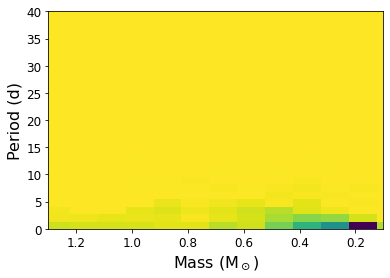

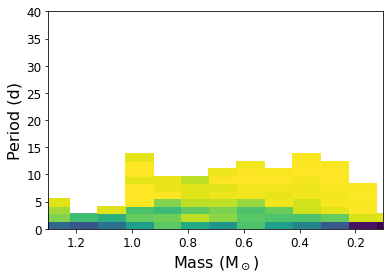

In [46]:
sm = SpinModel("Mattea2022",30,"linear")
sm.plot_hist()
sm.normalize()
sm.add_mask()
sm.plot_hist()

In [150]:
class PeriodMassDistribution:
    
    def __init__(self):
        # My crossmatched catalog
        per = at.read("tab_all_stars.csv")
        # per.dtype
        self.cat = Table(per, masked=True, copy=False)
        
        self.prot = self.cat["Prot1"]
        self.mass = self.cat["Mass"]
        self.prot_mask = self.cat["Prot1"].mask
        self.mass_mask = self.cat["Mass"].mask
        
        self.qmask = ((self.prot_mask==False) & (self.mass_mask==False) &  
                      (self.prot>0) & (self.cat["Q1"]==0))
        
        self.figsize=(9,9)
        
    def select_obs(self, sm):
        use = ((self.cat["Mass"]<max(sm.mass_bins)) & 
               (self.cat["Mass"]>=min(sm.mass_bins)) & 
               (self.cat["Mass"].mask==False) & 
               (self.cat["Prot1"]>0) & 
               (self.cat["Q1"]==0))

        self.prot = self.cat["Prot1"][use]
        self.mass = self.cat["Mass"][use]
        
    def plot_obs(self,ax=None,plot_errors=False):
        if ax is None:
            fig = plt.figure(figsize=self.figsize)
            ax = plt.subplot(111)
            ax.set_ylim(0.07,18)
            ax.set_xlim(1.3,0.1)
            ax.tick_params(labelsize=12)
            ax.set_xlabel(r"Mass (M$_\odot$)", fontsize=16)
            ax.set_ylabel("Period (d)", fontsize=16)            
            ax.patch.set_facecolor('w')
            ax.patch.set_alpha(1.0)
            fig.patch.set_facecolor('w')
            fig.patch.set_alpha(1.0)

        ax.errorbar(self.mass[self.qmask],self.prot[self.qmask],
                    xerr=self.cat["Mass_err"][self.qmask],
                    marker=None,linewidth=0,elinewidth=1,color="DarkGrey",alpha=0.75)
            
        ax.plot(self.mass,self.prot,"k.",ms=2,alpha=0.75)

        return ax
    
    def calc_mass_percentiles(self,mass_bins,percentiles=[0,10,50,75,100],ntests=1000):
        self.percentiles = percentiles
        
        mass_errs = self.cat["Mass_err"]
        nmass = len(mass_bins)-1
        
        # Define a set of benchmarks that have both periods and masses
        nb = len(np.where(self.qmask)[0])
        
        # Randomly generate 1000 mass samples
        rng = default_rng(42)
        new_masses = rng.normal(loc=self.mass[self.qmask],
                                scale=mass_errs[self.qmask],
                                size=(ntests,nb))
#         print(np.min(new_masses), np.max(new_masses))
        
        # Need to generate a set of percentiles for each mass bin
        nperc = len(self.percentiles)
        period_perc = np.zeros((nmass,nperc))
        
        for i in range(nmass):
            subset = (new_masses>=mass_bins[i]) & (new_masses<mass_bins[i+1])
            bin_perc = np.zeros((ntests,nperc))
            for j in range(ntests):
                if len(self.prot[self.qmask][subset[j]])>0:
                    bin_perc[j] = np.percentile(self.prot[self.qmask][subset[j]],self.percentiles)
                else:
                    bin_perc[j][:] = np.nan
            
            for k in range(nperc):
                period_perc[i][k] = np.nanmedian(bin_perc[:,k])
                
        self.period_perc = period_perc
        self.perc_mass_bins = mass_bins
        
    def plot_period_perc(self,ax=None):
        if self.period_perc is None:
            print("Please compute period percentiles first!")
            return None
        
        if ax is None:
            fig = plt.figure(figsize=self.figsize)
            ax = plt.subplot(111)
            ax.set_ylim(0.07,18)
            ax.set_xlim(1.3,0.1)
            ax.tick_params(labelsize=12)
            ax.set_xlabel(r"Mass (M$_\odot$)", fontsize=16)
            ax.set_ylabel("Period (d)", fontsize=16)            
            ax.patch.set_facecolor('w')
            ax.patch.set_alpha(1.0)
            fig.patch.set_facecolor('w')
            fig.patch.set_alpha(1.0)
        
        nmass = len(self.perc_mass_bins)-1
        bin_widths = np.diff(self.perc_mass_bins)
        bin_centers = self.perc_mass_bins[:-1]+bin_widths/2
        
        boxes = []
        for k in range(nmass):
            boxes.append({"whislo": self.period_perc[k][0],
                  "q1": self.period_perc[k][1],
                  "med": self.period_perc[k][2],
                  "q3": self.period_perc[k][3],
                  "whishi": self.period_perc[k][4],
                  "fliers": []
                 })
            
        colorprop = {"color":mapper.to_rgba(1),"linewidth":1.5}
        ax.bxp(bxpstats=boxes,positions=bin_centers,widths=bin_widths,
               medianprops=colorprop,boxprops=colorprop,whiskerprops=colorprop,
               capprops=colorprop,manage_ticks=False,zorder=20)

        return ax

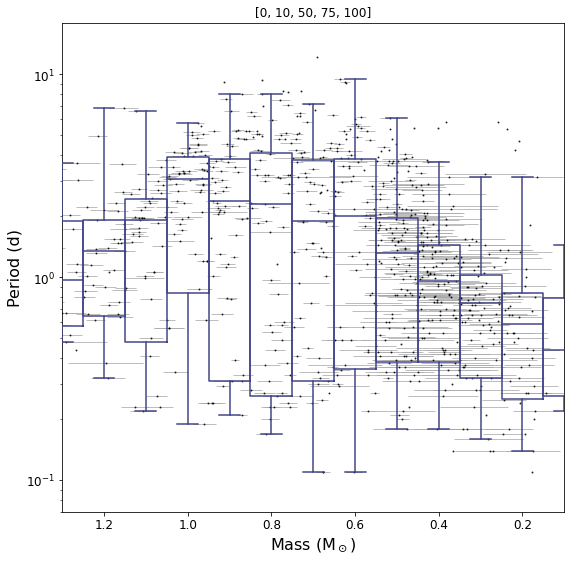

In [155]:
pmd = PeriodMassDistribution()
pmd.calc_mass_percentiles(mass_bins=np.linspace(0.05,1.35,14))
ax = pmd.plot_obs(plot_errors=True)
ax = pmd.plot_period_perc(ax)
_ = ax.set_title(pmd.percentiles)
ax.set_yscale("log")

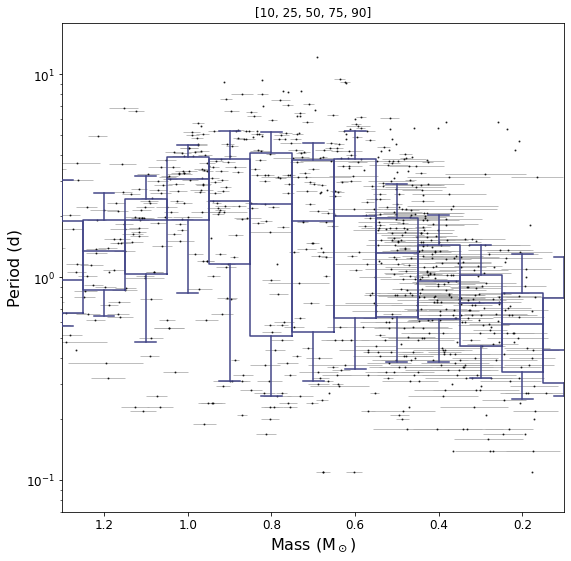

In [156]:
pmd = PeriodMassDistribution()
pmd.calc_mass_percentiles(mass_bins=np.linspace(0.05,1.35,14),percentiles=[10,25,50,75,90])
ax = pmd.plot_obs(plot_errors=True)
ax = pmd.plot_period_perc(ax)
_ = ax.set_title(pmd.percentiles)
ax.set_yscale("log")

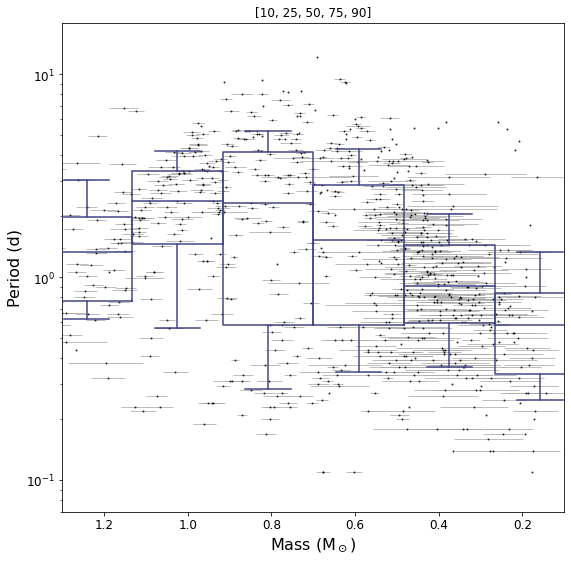

In [157]:
pmd = PeriodMassDistribution()
pmd.calc_mass_percentiles(mass_bins=np.linspace(0.05,1.35,7),percentiles=[10,25,50,75,90])
ax = pmd.plot_obs(plot_errors=True)
ax = pmd.plot_period_perc(ax)
_ = ax.set_title(pmd.percentiles)
ax.set_yscale("log")

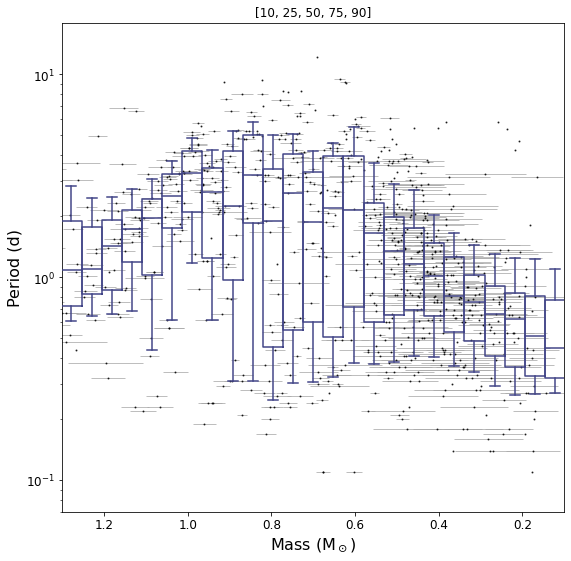

In [158]:
pmd = PeriodMassDistribution()
pmd.calc_mass_percentiles(mass_bins=np.linspace(0.05,1.35,28),percentiles=[10,25,50,75,90])
ax = pmd.plot_obs(plot_errors=True)
ax = pmd.plot_period_perc(ax)
_ = ax.set_title(pmd.percentiles)
ax.set_yscale("log")

Mattea2015
Mattea2022
ZeroTorque


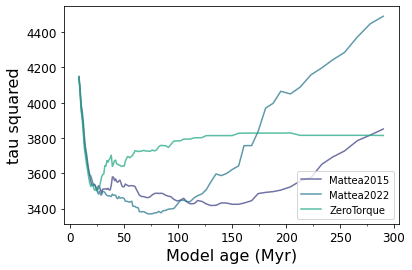

In [51]:
model_names = ["Mattea2015","Mattea2022","ZeroTorque"]
period_scale = "linear"

pmd = PeriodMassDistribution()

fig = plt.figure()
fig.patch.set_facecolor('w')
fig.patch.set_alpha(1.0)
for j,model in enumerate(model_names):
    print(model)
    models = glob.glob(os.path.expanduser(f"~/Dropbox/Models/UpSco_{model}/UpSco_{model}*Myr.txt"))
    # print(models)

    model_ages = np.sort([int(mod.split("_")[-1][:5]) for mod in models])
    # print(model_ages)
    
    model_ages = model_ages[model_ages<=300]
    
    all_tau_sq = np.zeros(len(model_ages))
    for i, age in enumerate(model_ages):
        sm = SpinModel(model,age,period_scale)
        
        # Normalize the model and calculate tau-squared
        sm.normalize()
        sm.add_mask()
        sm.calc_tau_sq(pmd)

        all_tau_sq[i] = sm.tau_sq

    plt.plot(model_ages,all_tau_sq,'-',label=model,color=mapper.to_rgba(j+1),alpha=0.75)
    plt.legend(loc=4)
    plt.xlabel("Model age (Myr)",fontsize=16)
    plt.ylabel("tau squared",fontsize=16)
#     plt.title(model,fontsize=14)
    
    ax = plt.gca()
    ax.tick_params(labelsize=12)
    ax.set_xticks(np.arange(0,300,25),minor=True)
plt.savefig(f"plots/tausq_ZAMS.png",bbox_inches="tight",dpi=600)

In [52]:
# Find all the model ages I have
# model_year = 2022

model_names = ["Mattea2015","Mattea2022","ZeroTorque"]
period_scale = "linear"

pmd = PeriodMass()

plt.figure()
for j,model in enumerate(model_names):
    print(model)
    models = glob.glob(os.path.expanduser(f"~/Dropbox/Models/UpSco_{model}/UpSco_{model}*Myr.txt"))
    
    model_ages = np.sort([int(mod.split("_")[-1][:5]) for mod in models])
    # print(model_ages)
    
    model_ages = model_ages[(model_ages<=500) & (model_ages>=0)]
    
    for i, age in enumerate(model_ages):
    #     print("\n",age)
    
        sm = SpinModel(model,age,period_scale)
        
        # Normalize the model and calculate tau-squared
        sm.normalize()
        sm.add_mask()
        sm.calc_tau_sq(pmd)
        
        # Plot
        ax = sm.plot_hist()
        pmd.plot_obs(ax)
        plt.savefig(f"plots/tausq_{model}_{period_scale}_{age:05d}Myr_ZAMS.png",bbox_inches="tight",dpi=600)
        plt.close()


Mattea2015
Mattea2022
ZeroTorque


<Figure size 432x288 with 0 Axes>